# AMG+ for 1D Laplace ($kh = 0$): 4/2 Non-Repetitive Coarsening
* Constant $k$. $k h$ designed so that wavelength evenly divides the domain.
* Discretization: 5-point (4th order).
* Kaczmarz relaxation.
* Fixed-domain problem; repetitive, so we sample windows from a test vector.
* Using ideal TVs.
* Interpolation LS fitting is weighted by $\|A x^{(k)}\|^{-1}$, where $k$ runs over test functions, and the norm is local (over 3 aggregates when fitting interpolation in an aggregate). This forces the interpolation row sums to be $1$, as the constant null-space vector has infinite LS weight. Thus $A^c$ is exactly singular and $b^c$ is exactly compatible with it at the coarse level in the cycle.

In [1]:
%run /Users/olivne/multigrid/amgplus/src/helmholtz/startup.ipy
import itertools

In [2]:
### Fixed seed for reproducible results.
np.random.seed(2)

# Domain size.
n = 200
domain_size = n   # With meshsize h = 1.
# Scaled wave number. Fit so lam_min = 0 (integer # periods in domain).
discretization = "3-point"
kh = 0
#kh = helmholtz.analysis.ideal.find_singular_kh(discretization, n)[0]
#kh = 0.2

repetitive = False

# Test vectors.
ideal_tv = False    # Use eigenvectors or not.
# Number of test vectors.  
num_examples = 20

# Set # sweeps manually here.
num_sweeps_on_vectors = None
threshold = 0.1

# Boottstrapping parameters.
interpolation_method = "ls" # "weighted_ls" #"ls"
fit_scheme = "plain" # "ridge" #"plain"
weighted = False #True
neighborhood = "extended" #"aggregate" # "extended"
num_test_examples = 5
leeway_factor = 1.3

_LOGGER.info("n {} kh {}".format(n, kh))

INFO     n 200 kh 0


## Level 0->1 Coarsening

In [3]:
# Create fine-level matrix.
a = hm.linalg.helmholtz_1d_discrete_operator(kh, discretization, n)
# Use default = Kacmzarz relaxation for kh != 0.
#level = hm.setup.hierarchy.create_finest_level(a, relaxer=hm.solve.relax.GsRelaxer(a, scipy.sparse.eye(a.shape[0])) if kh == 0 else None)
level = hm.setup.hierarchy.create_finest_level(a, relaxer=None)

# Initialize hierarchy to 1-level.
finest = 0
multilevel = hm.setup.hierarchy.multilevel.Multilevel.create(level)

# 'location' is an array of variable locations at all levels. Used only for interpolation neighbor determination.
# Finest-level variable ocations are assumed to be [0..n-1], i.e. a domain of size n with meshsize h = 1.
level.location = np.arange(n)

# TV and TV residual history.
x_log = []
r_log = []

# Save null-space vectors so we dan orthogonalize error vectors to them.
num_eigenvectors = 10
z, lam = hm.analysis.ideal.ideal_tv(level.a, num_eigenvectors)
ind = (np.abs(lam[:num_eigenvectors]) < 1e-6)
z = z[:, ind]
z = hm.linalg.gram_schmidt(z)

### Relaxation

INFO     relax
INFO     Iter     |r|                         |x|         RER
INFO     0     1.081e+00                    4.470e-01    2.416
INFO     1     5.630e-01 (0.521) [0.521]    3.257e-01    1.730 (0.716)
INFO     2     3.110e-01 (0.553) [0.537]    2.718e-01    1.147 (0.663)
INFO     3     1.907e-01 (0.614) [0.562]    2.456e-01    0.780 (0.680)
INFO     4     1.310e-01 (0.687) [0.591]    2.305e-01    0.571 (0.733)
INFO     5     9.915e-02 (0.756) [0.621]    2.205e-01    0.452 (0.791)
INFO     6     8.060e-02 (0.812) [0.650]    2.133e-01    0.380 (0.840)
INFO     7     6.859e-02 (0.850) [0.675]    2.076e-01    0.332 (0.874)
INFO     8     6.010e-02 (0.876) [0.698]    2.030e-01    0.298 (0.896)
INFO     9     5.373e-02 (0.894) [0.717]    1.992e-01    0.271 (0.911)
INFO     10    4.873e-02 (0.907) [0.734]    1.960e-01    0.250 (0.922)
INFO     11    4.468e-02 (0.917) [0.749]    1.932e-01    0.233 (0.930)
INFO     12    4.134e-02 (0.925) [0.762]    1.907e-01    0.218 (0.937)
INFO    

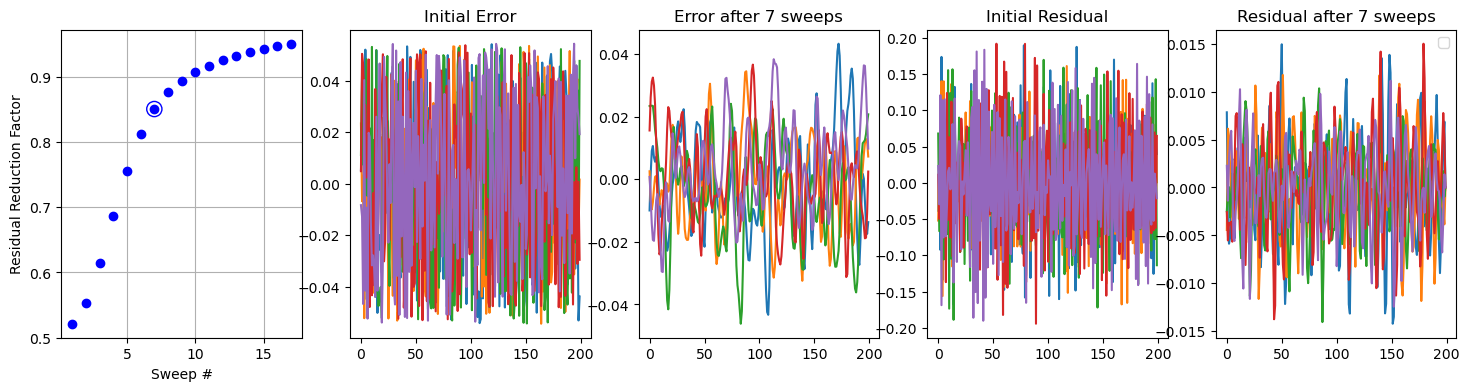

In [4]:
np.random.seed(0)
method_info = hm.solve.smoothing.check_relax_cycle_shrinkage(
    multilevel, num_levels=1, leeway_factor=leeway_factor, slow_conv_factor=0.95, num_examples=5)
num_sweeps = method_info["relax"][1]

In [5]:
nu = num_sweeps_on_vectors if num_sweeps_on_vectors is not None else num_sweeps
# Generate initial test vectors.
level = multilevel[0]
if ideal_tv:
    _LOGGER.info("Generating {} ideal TVs".format(num_examples))
    x, lam = hm.analysis.ideal.ideal_tv(level.a, num_examples)
else:
    _LOGGER.info("Generating {} TVs with {} sweeps".format(num_examples, nu))
    x = hm.setup.auto_setup.get_test_matrix(a, nu, num_examples=num_examples)
    _LOGGER.info("RER {:.3f}".format(norm(level.a.dot(x)) / norm(x)))
x_log.append(x)

INFO     Generating 20 TVs with 7 sweeps
INFO     RER 0.331


### Coarsening Level 0->1: Fixed (2/1)

In [6]:
# Coarsening. Force 2 coarse vars per aggregate so we can test alignment.
aggregate_size = 4
num_components = 2

nu  10 s [1.    0.391 0.096 0.012] Energy error [0.374 0.09  0.012 0.   ]
INFO     Mock cycle conv [0.476 0.225 0.155 0.137 0.103 0.062 0.063 0.052 0.046 0.041 0.037]


array([[ 0.505,  0.546,  0.514,  0.427],
       [ 0.58 ,  0.258, -0.231, -0.737]])

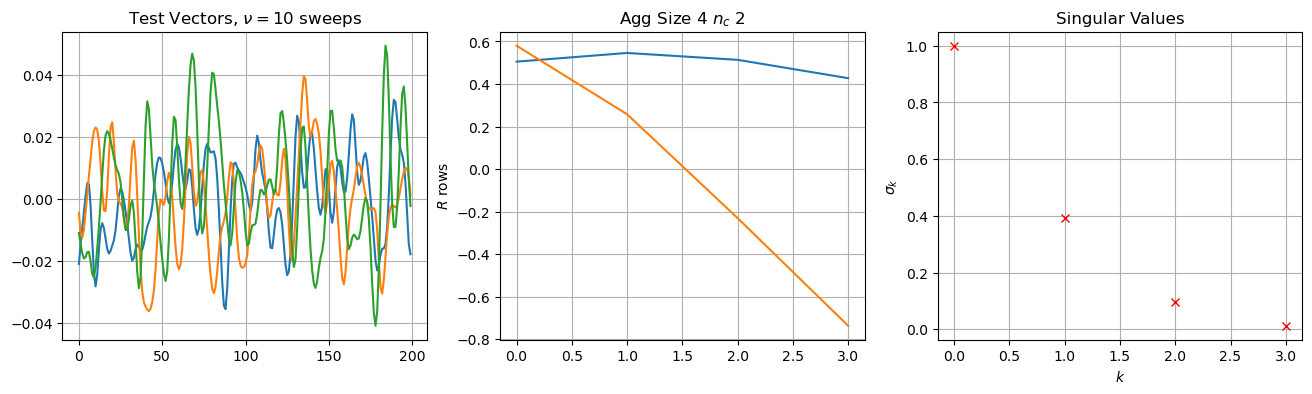

In [7]:
helmholtz.analysis.plots.plot_svd_coarsening_accuracy(level, 10, aggregate_size, num_components)

,0,1,2,3,4,5,6,7,8,9
0,-0.4618,-0.5361,-0.5406,-0.4552,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
1,-0.6689,-0.2429,0.2642,0.6509,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
2,0.0000,0.0000,0.0000,0.0000,-0.4618,-0.5361,-0.5406,-0.4552,0.0000,0.0000
3,0.0000,0.0000,0.0000,0.0000,-0.6689,-0.2429,0.2642,0.6509,0.0000,0.0000
4,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,-0.4618,-0.5361


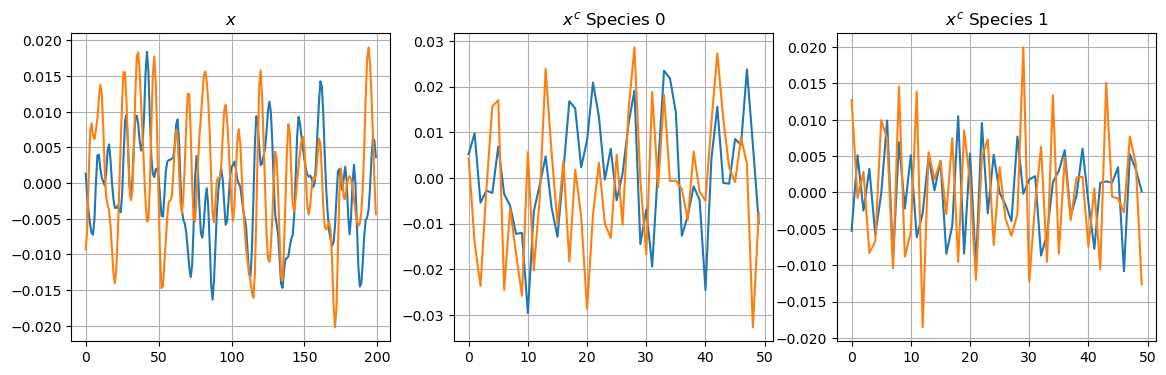

In [8]:
r, s = hm.repetitive.locality.create_coarsening(x, aggregate_size, num_components, normalize=False)
R = r.tile(level.size // aggregate_size)
xc = R.dot(x)
display(pd.DataFrame(R[:5,:10].todense()))
hm.repetitive.locality.plot_coarsening(R, x)

### Two-level Rates
Calculated with 100 relaxations on the coarse level.

In [202]:
np.random.seed(1001)
nu = 10 # num_sweeps_on_vectors if num_sweeps_on_vectors is not None else num_sweeps
nu_coarsest = -1 # -1
m = None #8

coarsening_types = [
    ("P^T A P caliber 2", 2, "pt"),
    ("P^T A P caliber 3", 3, "pt"),
    ("P^T A P caliber 4", 4, "pt"),
    # ("Q A P caliber 4", 4, "q"),
    # ("R A P caliber 4", 4, "r"),
]

all_conv, r, p_caliber, q = helmholtz.analysis.stats.compare_coarsening(level, coarsening_types, nu, 
                       domain_size,
                       aggregate_size, num_components,
                       ideal_tv=ideal_tv,
                       num_examples=num_examples,
                       nu_coarsest=nu_coarsest,
                       interpolation_method=interpolation_method,
                       fit_scheme=fit_scheme,                                
                       weighted=weighted,
                       neighborhood=neighborhood,
                       repetitive=True, #repetitive,
                       m=m)

styler = all_conv.style.set_caption("Convergence Factors").format(precision=4)
display_html(styler._repr_html_(), raw=True)

INFO     Generating 20 TVs with 10 sweeps
INFO     RER 0.263


,Fill-in,Symmetry,1,2,3,4,5,6,7,8,9,10,11
Mock,nan,nan,0.4771,0.2247,0.1514,0.1344,0.0992,0.0530,0.0549,0.0430,0.0374,0.0355,0.0315
P^T A P caliber 2,2.0000,0.0000,0.9018,0.9094,0.9197,0.9176,0.9206,0.9239,0.9276,0.9243,0.9269,0.9233,0.9006
P^T A P caliber 3,2.3333,0.0000,0.7456,0.5843,0.4888,0.4774,0.4872,0.5125,0.5303,0.5396,0.5414,0.5397,0.5371
P^T A P caliber 4,3.3333,0.0000,0.8196,0.6761,0.6150,0.6066,0.6188,0.6380,0.6513,0.6582,0.6590,0.6575,0.6554


* The SVD intepolation is good up to $\nu = 2$, conv $\approx 0.36$. This is similar to the case of Laplace + 2/1 coarsening, where $P$ is only first-order.
* Caliber 2 is equivalent to $P = R^T$.
* Caliber 3 is insufficient, oonly gives marginally better convergence than $P = R^T$.
* Caliber 4 Galerkin gives ideal rates (up to $0.11$).
* Caliber 4 $P$ with $R A P$ is slightly non-symmetric but sparser than $P^T A P$. It gives an intermediate performance between $R A R^R$ and $P^T A P$ (up to $0.18$). 

In [157]:
# Pick an interpolation operator P:1->0 to work with. We use a high-order (caliber 4) P.
p = p_caliber[2]

In [158]:
p.todense()[:20,:10]

matrix([[0.546, 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ],
        [0.572, 0.213, 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ],
        [0.239, 0.546, 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ],
        [0.   , 0.572, 0.213, 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ],
        [0.   , 0.239, 0.546, 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ],
        [0.   , 0.   , 0.572, 0.213, 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ],
        [0.   , 0.   , 0.239, 0.546, 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ],
        [0.   , 0.   , 0.   , 0.572, 0.213, 0.   , 0.   , 0.   , 0.   , 0.   ],
        [0.   , 0.   , 0.   , 0.239, 0.546, 0.   , 0.   , 0.   , 0.   , 0.   ],
        [0.   , 0.   , 0.   , 0.   , 0.572, 0.213, 0.   , 0.   , 0.   , 0.   ],
        [0.   , 0.   , 0.   , 0.   , 0.239, 0.546, 0.   , 0.   , 0.   , 0.   ],
        [0.   , 0.   , 0.   , 0.   , 0.   , 0.572, 0.213, 0.   , 0.   , 0.   ],
        [0.   , 0.   , 0.   , 0.   , 0. 

### Solving $Ax = b$ - Convergence History

INFO     Iter   |r|        Factor   RER    Factor   |e|   
INFO     0      9.935e+00           1.213           8.193
INFO     1      1.201e+00  (0.121)  1.530  (1.261)  0.785
INFO     2      1.430e-01  (0.119)  0.041  (0.027)  3.470
INFO     3      1.787e-02  (0.125)  0.005  (0.126)  3.455
INFO     4      2.313e-03  (0.129)  0.001  (0.130)  3.441
INFO     5      3.063e-04  (0.132)  0.000  (0.132)  3.441
INFO     6      4.095e-05  (0.134)  0.000  (0.134)  3.441
INFO     7      5.558e-06  (0.136)  0.000  (0.136)  3.441
INFO     8      7.612e-07  (0.137)  0.000  (0.137)  3.441
INFO     9      1.048e-07  (0.138)  0.000  (0.138)  3.441
INFO     10     1.454e-08  (0.139)  0.000  (0.139)  3.441
INFO     11     2.028e-09  (0.139)  0.000  (0.139)  3.441
INFO     12     2.841e-10  (0.140)  0.000  (0.140)  3.441
INFO     13     3.996e-11  (0.141)  0.000  (0.141)  3.441


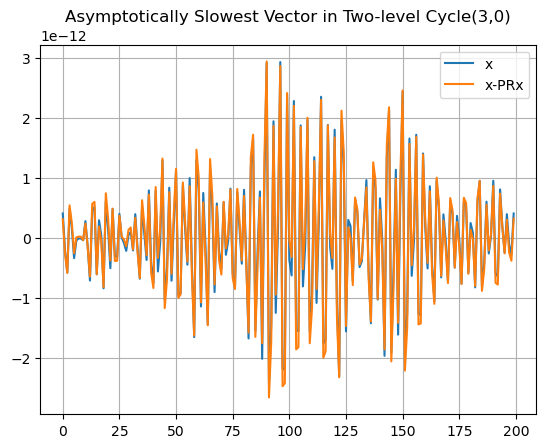

In [168]:
# TODO(orenlivne): define error as (x-x0) projected onto range(a).
nu = 3

m0 = hm.repetitive.locality.create_two_level_hierarchy_from_matrix(
    level.a, level.location, r, p, p.T, aggregate_size, num_components)

y, _ = hm.repetitive.locality.two_level_conv_factor(m0, nu, nu_post=0, nu_coarsest=-1, print_frequency=1, debug=False)

# Asymptotic vector.
plt.title("Asymptotically Slowest Vector in Two-level Cycle({},0)".format(nu))
y -= y.mean() # Remove zero component.
e = y - m0[1].interpolate(m0[1].coarsen(y))
plt.plot(y, label="x");
plt.plot(e, label="x-PRx");
plt.grid(True);
plt.legend();

In [169]:
# Calculate eigenpairs at all levels.
laml, vl_finest = hm.analysis.ideal.compare_spectrum(m0)
for l, lam in enumerate(laml):
    print(l, "lam", np.array2string(lam[:12], precision=3))

0 lam [-0.    -0.001 -0.001 -0.004 -0.004 -0.009 -0.009 -0.016 -0.016 -0.025 -0.025 -0.035]
1 lam [-0.    -0.001 -0.001 -0.005 -0.005 -0.011 -0.011 -0.02  -0.02  -0.03  -0.03  -0.043]


In [170]:
pd.set_option("display.precision", 8)
pd.DataFrame(m0[0].a.todense()[2:4, :6])

,0,1,2,3,4,5
0,0.0000,1.0000,-2.0000,1.0000,0.0000,0.0000
1,0.0000,0.0000,1.0000,-2.0000,1.0000,0.0000


In [171]:
pd.set_option("display.precision", 3)
pd.DataFrame(m0[1].a.todense()[2:4, :6])

,0,1,2,3,4,5
0,0.0511,0.1116,-0.3253,0.1116,0.0511,0.0000
1,0.0000,0.0511,0.1116,-0.3253,0.1116,0.0511


In [109]:
pd.DataFrame((m0[1].a - m0[1].a.transpose()).todense()[:10, :10])

,0,1,2,3,4,5,6,7,8,9
0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
1,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
2,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
3,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
4,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
5,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
6,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
7,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
8,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
9,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000


## Level 1->2 Coarsening
Are the equations at level 1 harder to solve than level 0 because of worse smoothing rates? Do we see a good coarsening ratio for an aggregate of size $4$ here too?

In [24]:
# Coarsening. Force 2 coarse vars per aggregate so we can test alignment.
aggregate_size = 4
num_components = 2

num_sweeps_on_vectors = None # 100

## Level 1 Relaxation

We run relaxation on $A x = 0$. $A$ has two null vectors; call $Y$ the $n \times 2$ matrix whose columns are these vectors. Let $x_0$ be a random[-1, 1] initial guess for $x$. We first project $x_0$ onto the range of $A$, that is,

$x_0 \longleftarrow x_0 - Y Y^T x_0^T\,,$

and use this as the initial guess for the run. Since the magnitude of $Y$ the exact solution is $0$, and relaxation doesn't change this magnitude, $e = x - x_0$ is a meaningful definition, which can also be used to calculate a meaningful RER.

In [25]:
m1 = m0.sub_hierarchy(1)
level = m1.finest_level
a = level.a

INFO     Kaczmarz
INFO     Iter     |r|                         |x|         RER
INFO     0     2.475e-01                    4.455e-01    0.556
INFO     1     9.955e-02 (0.401) [0.401]    2.718e-01    0.365 (0.659)
INFO     2     4.876e-02 (0.492) [0.445]    2.110e-01    0.230 (0.635)
INFO     3     2.986e-02 (0.622) [0.496]    1.844e-01    0.164 (0.715)
INFO     4     2.268e-02 (0.771) [0.552]    1.684e-01    0.139 (0.847)
INFO     5     1.806e-02 (0.802) [0.594]    1.574e-01    0.119 (0.862)
INFO     6     1.529e-02 (0.848) [0.630]    1.496e-01    0.107 (0.896)
INFO     7     1.336e-02 (0.872) [0.660]    1.436e-01    0.098 (0.913)
INFO     8     1.191e-02 (0.889) [0.685]    1.387e-01    0.091 (0.924)
INFO     9     1.076e-02 (0.900) [0.707]    1.346e-01    0.085 (0.930)
INFO     10    9.812e-03 (0.908) [0.725]    1.311e-01    0.080 (0.935)
INFO     11    9.025e-03 (0.915) [0.741]    1.280e-01    0.075 (0.940)
INFO     12    8.361e-03 (0.922) [0.755]    1.253e-01    0.071 (0.944)
INFO 

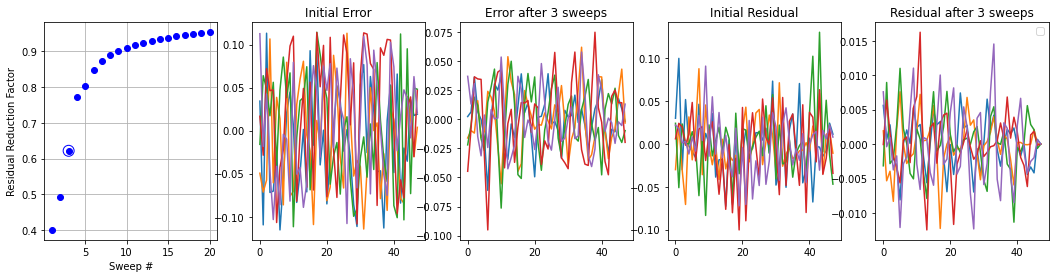

In [26]:
method_info = hm.solve.smoothing.check_relax_cycle_shrinkage(
    m1, num_levels=1, leeway_factor=leeway_factor, slow_conv_factor=0.98, max_sweeps=20)
num_sweeps = method_info["relax"][1]

nu 100 s [1.    0.798 0.011 0.002] Energy error [0.624 0.009 0.001 0.   ]
INFO     Mock cycle conv [0.29  0.168 0.142 0.13  0.105 0.096 0.081 0.07  0.058 0.05  0.038]


array([[-0.681,  0.19 ,  0.647,  0.285],
       [ 0.444,  0.552,  0.517, -0.481]])

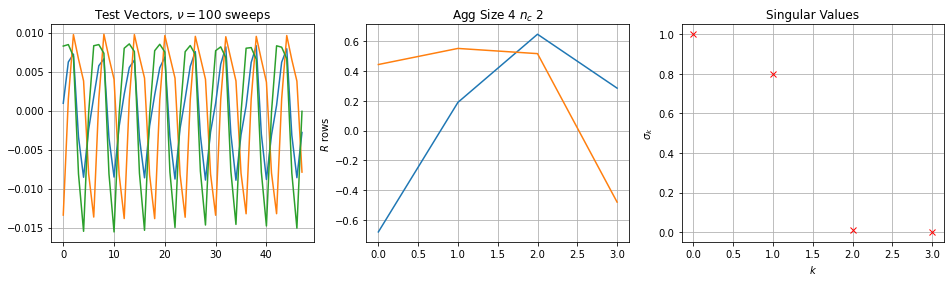

In [27]:
# #PCs revealed by relaxed vectors of increasing smoothness.
helmholtz.analysis.plots.plot_svd_coarsening_accuracy(level, 100, aggregate_size, num_components)

In [28]:
pd.DataFrame(level.a.todense()[10:12, 8:14])

,0,1,2,3,4,5
0,0.1517,0.1912,-0.0428,0.0334,0.1517,-0.1616
1,-0.1616,-0.1504,0.0334,-0.6582,0.1912,-0.1504


In [29]:
ideal_tv = False # True
num_examples = 5
nu = num_sweeps_on_vectors if num_sweeps_on_vectors is not None else 2 * num_sweeps
# Generate initial test vectors.
if ideal_tv:
    _LOGGER.info("Generating {} ideal TVs".format(num_examples))
    x, lam = hm.analysis.ideal.ideal_tv(level.a, num_examples)
else:
    _LOGGER.info("Generating {} TVs with {} sweeps".format(num_examples, nu))
    x = hm.setup.auto_setup.get_test_matrix(a, nu, num_examples=num_examples)
    _LOGGER.info("RER {:.3f}".format(norm(level.a.dot(x)) / norm(x)))
x_log.append(x)

INFO     Generating 5 TVs with 6 sweeps
INFO     RER 0.082


[1.    0.823 0.218 0.028]
(24, 48)


,0,1,2,3,4,5,6,7,8,9
0,0.6056,-0.2460,-0.7250,-0.2172,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
1,0.5567,0.4877,0.4494,-0.5002,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
2,0.0000,0.0000,0.0000,0.0000,0.6056,-0.2460,-0.7250,-0.2172,0.0000,0.0000
3,0.0000,0.0000,0.0000,0.0000,0.5567,0.4877,0.4494,-0.5002,0.0000,0.0000
4,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.6056,-0.2460


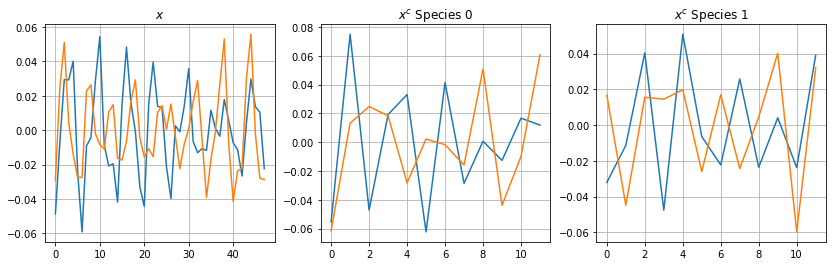

In [30]:
r, s = hm.repetitive.locality.create_coarsening(x, aggregate_size, num_components, normalize=False)
print(s/s[0])
R = r.tile(level.size // aggregate_size)
print(R.shape)
xc = R.dot(x)
display(pd.DataFrame(R[:5,:10].todense()))
hm.repetitive.locality.plot_coarsening(R, x)

### Two-level Rates
Calculated with an exact solver on the coarse level.

In [31]:
nu = num_sweeps_on_vectors if num_sweeps_on_vectors is not None else num_sweeps
aggregate_size = 4
num_components = 2
nu_coarsest = -1 # 100
m = None #8

coarsening_types = [
    ("P^T A P caliber 2", 2, "pt"),
    ("P^T A P caliber 3", 3, "pt"),
    ("P^T A P caliber 4", 4, "pt"),
    ("Q A P caliber 4", 4, "q"),
    ("R A P caliber 4", 4, "r"),
]

all_conv, r, p_caliber, q = helmholtz.analysis.stats.compare_coarsening(level, coarsening_types, nu, 
                       domain_size,
                       aggregate_size, num_components,
                       ideal_tv=ideal_tv,
                       num_examples=num_examples,
                       nu_coarsest=nu_coarsest,
                       interpolation_method=interpolation_method,
                       fit_scheme=fit_scheme,
                       weighted=weighted,
                       neighborhood=neighborhood,
                       repetitive=repetitive,
                       m=m)

styler = all_conv.style.set_caption("Convergence Factors").format(precision=4)
display_html(styler._repr_html_(), raw=True)

INFO     Generating 5 TVs with 3 sweeps
INFO     RER 0.183


,Fill-in,Symmetry,1,2,3,4,5,6,7,8,9,10,11
Mock,nan,nan,0.4350,0.2459,0.1310,0.1162,0.1017,0.0863,0.0799,0.0793,0.0677,0.0739,0.0700
P^T A P caliber 2,1.0000,0.0000,4.6207,3.1021,2.7762,2.7292,2.4640,2.2051,2.0109,1.8819,1.7944,1.6924,1.6040
P^T A P caliber 3,1.1667,0.0000,2.6857,2.0009,1.7716,1.5425,1.3349,1.1592,1.0045,0.8702,0.7531,0.6509,0.5604
P^T A P caliber 4,1.6667,0.0000,0.9351,0.5780,0.6363,0.6595,0.7118,0.7145,0.7248,0.7246,0.7270,0.7257,0.7188
Q A P caliber 4,1.0000,0.0000,1.7798,1.4292,0.7457,0.6360,0.6280,0.6199,0.6159,0.6092,0.6238,0.6233,0.6071
R A P caliber 4,1.0000,0.0232,7.5312,7.1977,3.0636,0.7866,0.5975,0.6011,0.5927,0.5944,0.6322,0.6147,0.6170


Now, calculate the rates with 100 relaxations at the coarse level.

In [32]:
nu = num_sweeps_on_vectors if num_sweeps_on_vectors is not None else 2 * num_sweeps
aggregate_size = 4
num_components = 2
nu_coarsest = -1 # 10
m = None #8

coarsening_types = [
    ("P^T A P caliber 2", 2, "pt"),
    ("P^T A P caliber 3", 3, "pt"),
    ("P^T A P caliber 4", 4, "pt"),
    ("Q A P caliber 4", 4, "q"),
    ("R A P caliber 4", 4, "r"),
]

all_conv, r, p_caliber, q = helmholtz.analysis.stats.compare_coarsening(level, coarsening_types, nu, 
                       domain_size,
                       aggregate_size, num_components,
                       ideal_tv=ideal_tv,
                       num_examples=num_examples,
                       nu_coarsest=nu_coarsest,
                       interpolation_method=interpolation_method,
                       fit_scheme=fit_scheme,
                       weighted=weighted,
                       neighborhood=neighborhood,
                       repetitive=repetitive,
                       m=m)

styler = all_conv.style.set_caption("Convergence Factors").format(precision=4)
display_html(styler._repr_html_(), raw=True)

INFO     Generating 5 TVs with 6 sweeps
INFO     RER 0.131


,Fill-in,Symmetry,1,2,3,4,5,6,7,8,9,10,11
Mock,nan,nan,0.3135,0.2655,0.2118,0.1879,0.1618,0.1154,0.1184,0.0997,0.0837,0.0685,0.0561
P^T A P caliber 2,1.0000,0.0000,4.0765,1.7647,1.5800,1.3266,1.4743,1.6243,1.7712,1.8200,1.7607,1.7700,1.8186
P^T A P caliber 3,1.1667,0.0000,5.0329,3.0790,2.6043,2.2625,2.0139,1.8279,1.5921,1.4605,1.3729,1.4130,1.2234
P^T A P caliber 4,1.6667,0.0000,0.7433,0.4312,0.2118,0.0783,0.0563,0.0426,0.0382,0.0343,0.0284,0.0234,0.0239
Q A P caliber 4,1.0000,0.0000,5.8991,2.9784,0.6860,0.5988,0.5197,0.3363,0.2405,0.1826,0.1358,0.0926,0.1021
R A P caliber 4,1.0000,0.0113,3.2474,1.6757,0.4154,0.3328,0.2922,0.1758,0.1371,0.0919,0.0805,0.0838,0.0909


### Solving $Ax = b$ - Convergence History
If we don't solve exactly at the coarsest level, the cycle stalls.

INFO     Iter   |r|        Factor   RER    Factor   |e|   
INFO     0      3.297e+00           0.578           5.709
INFO     1      7.061e-01  (0.214)  0.463  (0.801)  1.525
INFO     2      7.791e-02  (0.110)  0.210  (0.453)  0.372
INFO     3      1.636e-02  (0.210)  0.093  (0.442)  0.177
INFO     4      3.839e-03  (0.235)  0.043  (0.459)  0.090
INFO     5      1.515e-03  (0.395)  0.032  (0.763)  0.047
INFO     6      8.292e-04  (0.547)  0.034  (1.058)  0.024
INFO     7      4.723e-04  (0.570)  0.038  (1.100)  0.013
INFO     8      2.644e-04  (0.560)  0.041  (1.080)  0.006
INFO     9      1.441e-04  (0.545)  0.043  (1.049)  0.003
INFO     10     7.646e-05  (0.531)  0.044  (1.019)  0.002
INFO     11     3.951e-05  (0.517)  0.043  (0.990)  0.001
INFO     12     1.988e-05  (0.503)  0.042  (0.963)  0.000
INFO     13     9.738e-06  (0.490)  0.039  (0.936)  0.000
INFO     14     4.635e-06  (0.476)  0.035  (0.909)  0.000
INFO     15     2.142e-06  (0.462)  0.031  (0.883)  0.000
INFO     16  

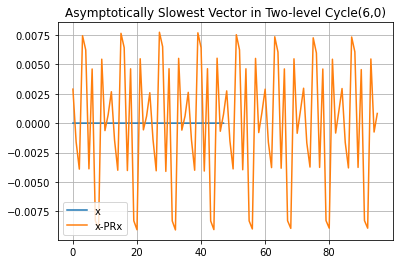

In [33]:
# TODO(orenlivne): define error as (x-x0) projected onto range(a).
nu = 6
p = p_caliber[4] # P^T*A*P P high order

m1 = hm.repetitive.locality.create_two_level_hierarchy_from_matrix(
    level.a, level.location, R, p, q, aggregate_size, num_components)

y, _ = hm.repetitive.locality.two_level_conv_factor(m1, nu, print_frequency=1, nu_coarsest=100,
                                                    debug=False)

# Asymptotic vector.
plt.title("Asymptotically Slowest Vector in Two-level Cycle({},0)".format(nu))
# y -= y.mean() # Remove zero component.
# e = y - multilevel[1].p.dot(multilevel[1].r.dot(y))
plt.plot(y, label="x");
plt.plot(e, label="x-PRx");
plt.grid(True);
plt.legend();

### Level 2 relaxation shrinkage
Relaxation does converge.

Finest level 24
INFO     Kaczmarz
INFO     Iter     |r|                         |x|         RER
INFO     0     5.297e-02                    4.465e-01    0.120
INFO     1     1.804e-02 (0.354) [0.354]    3.145e-01    0.058 (0.501)
INFO     2     1.121e-02 (0.624) [0.469]    2.805e-01    0.042 (0.709)
INFO     3     8.095e-03 (0.727) [0.542]    2.617e-01    0.033 (0.786)
INFO     4     6.172e-03 (0.764) [0.590]    2.499e-01    0.027 (0.805)
INFO     5     4.992e-03 (0.809) [0.629]    2.417e-01    0.022 (0.841)
INFO     6     4.219e-03 (0.845) [0.660]    2.358e-01    0.019 (0.870)
INFO     7     3.693e-03 (0.875) [0.688]    2.311e-01    0.017 (0.895)
INFO     8     3.326e-03 (0.901) [0.711]    2.274e-01    0.016 (0.918)
INFO     9     3.059e-03 (0.920) [0.732]    2.242e-01    0.015 (0.934)
INFO     10    2.856e-03 (0.934) [0.750]    2.215e-01    0.014 (0.947)
INFO     11    2.697e-03 (0.944) [0.766]    2.191e-01    0.013 (0.956)
INFO     12    2.571e-03 (0.953) [0.780]    2.169e-01    0.0

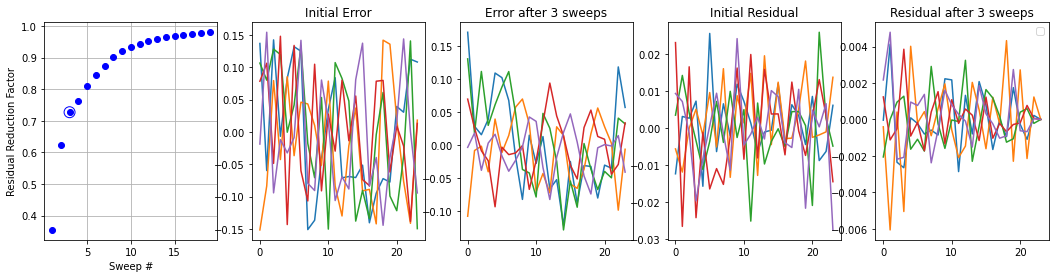

In [34]:
m2 = m1.sub_hierarchy(1)
print("Finest level", m2[0].size)
method_info = hm.solve.smoothing.check_relax_cycle_shrinkage(
    m2, num_levels=1, leeway_factor=leeway_factor, slow_conv_factor=0.98, max_sweeps=20)
num_sweeps = method_info["relax"][1]

INFO     Kaczmarz
INFO     Iter     |r|                         |x|         RER
INFO     0     2.595e-01                    4.460e-01    0.584
INFO     1     1.094e-01 (0.422) [0.422]    2.620e-01    0.424 (0.728)
INFO     2     5.310e-02 (0.488) [0.453]    1.853e-01    0.294 (0.696)
INFO     3     3.111e-02 (0.587) [0.494]    1.541e-01    0.211 (0.714)
INFO     4     2.229e-02 (0.716) [0.542]    1.365e-01    0.173 (0.817)
INFO     5     1.715e-02 (0.766) [0.582]    1.256e-01    0.146 (0.840)
INFO     6     1.392e-02 (0.804) [0.616]    1.182e-01    0.125 (0.861)
INFO     7     1.169e-02 (0.832) [0.644]    1.128e-01    0.110 (0.876)
INFO     8     1.011e-02 (0.857) [0.668]    1.087e-01    0.098 (0.894)
INFO     9     8.980e-03 (0.881) [0.690]    1.053e-01    0.090 (0.912)
INFO     10    8.138e-03 (0.900) [0.709]    1.024e-01    0.084 (0.928)
INFO     Relax conv 0.90 shrinkage 0.54 PODR RER 0.17 after 4 sweeps. Work 1.0 eff 0.54
INFO     2-level MiniCycle
INFO     Iter     |r|           

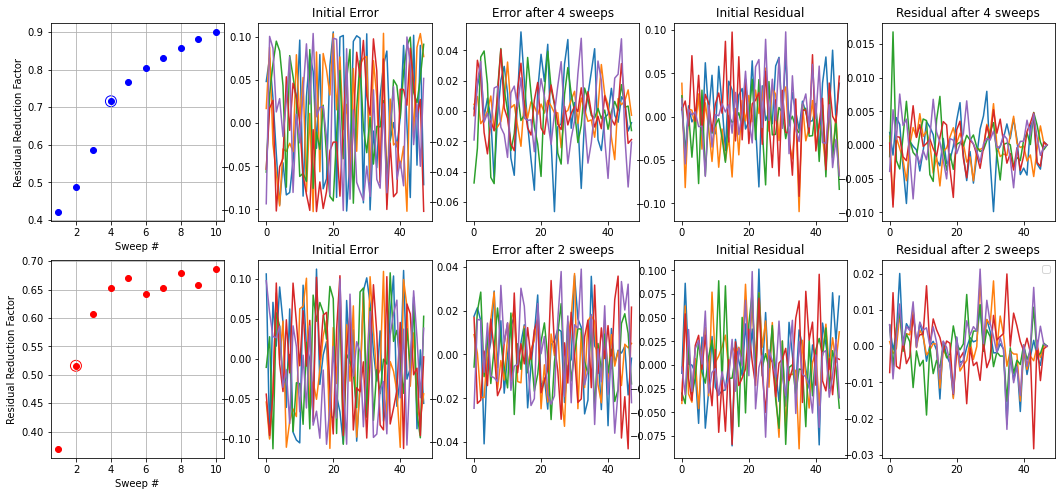

In [35]:
method_info = hm.solve.smoothing.check_relax_cycle_shrinkage(
    m1, num_levels=2, leeway_factor=leeway_factor, slow_conv_factor=1.3, max_sweeps=10,
    nu_pre=1, nu_post=1, nu_coarsest=10)

In [36]:
pd.DataFrame(m1[1]._r.todense()[:2, :4])

,0,1,2,3
0,0.6056,-0.2460,-0.7250,-0.2172
1,0.5567,0.4877,0.4494,-0.5002


In [37]:
# Calculate eigenpairs at all levels.
laml, vl_finest = hm.analysis.ideal.compare_spectrum(m1)
for l, lam in enumerate(laml):
    print(l, "lam", lam[:12], lam[0])

0 lam [-0.007 -0.007  0.061  0.061 -0.085 -0.085  0.119  0.119  0.166  0.166 -0.169 -0.169] -0.00731606703519278
1 lam [-0.007 -0.007 -0.007 -0.007 -0.021  0.031  0.031  0.06   0.06   0.084  0.084  0.084] -0.0067264116590857025


## 3-Level Method
With $Q A P$ coarsening at level $0$ and $R A P$ at leve1 1.

In [38]:
ml = hm.setup.hierarchy.multilevel.Multilevel.create(m0[0])
ml.add(m0[1])
ml.add(m1[1])

In [39]:
nu_pre = 5
nu_post = 2
y, _ = hm.repetitive.locality.two_level_conv_factor(ml, nu_pre, nu_post=nu_post, print_frequency=1, debug=False,
                                                   nu_coarsest=20)

# Asymptotic vector.
#plt.title("Asymptotically Slowest Vector in Cycle({}, 0)".format(nu_pre, nu_post))
# # y -= y.mean() # Remove zero component.
# # e = y - multilevel[1].p.dot(multilevel[1].r.dot(y))
# plt.plot(y, label="x");
# plt.plot(e, label="x-PRx");
# plt.grid(True);
# plt.legend();

INFO     Iter   |r|        Factor   RER    Factor   |e|   
INFO     0      1.600e+01           1.892           8.458
INFO     1      8.143e-01  (0.051)  0.507  (0.268)  1.606
INFO     2      9.417e-02  (0.116)  0.069  (0.137)  1.360
INFO     3      1.021e-02  (0.108)  0.008  (0.109)  1.359
INFO     4      1.312e-03  (0.128)  0.001  (0.128)  1.359
INFO     5      1.690e-04  (0.129)  0.000  (0.129)  1.359
INFO     6      2.160e-05  (0.128)  0.000  (0.128)  1.359
INFO     7      2.705e-06  (0.125)  0.000  (0.125)  1.359
INFO     8      3.357e-07  (0.124)  0.000  (0.124)  1.359
INFO     9      4.182e-08  (0.125)  0.000  (0.125)  1.359
INFO     10     5.295e-09  (0.127)  0.000  (0.127)  1.359
INFO     11     6.692e-10  (0.126)  0.000  (0.126)  1.359
INFO     12     8.492e-11  (0.127)  0.000  (0.127)  1.359


In [40]:
# Calculate eigenpairs at all levels.
laml, vl_finest = hm.analysis.ideal.compare_spectrum(ml)
for l, lam in enumerate(laml):
    print(l, "lam", lam[:21])

0 lam [-0.     0.     0.064  0.064 -0.073 -0.073  0.12   0.12  -0.154 -0.154  0.167  0.167  0.205  0.205  0.235  0.235 -0.243 -0.243  0.257  0.257  0.27 ]
1 lam [-0.007 -0.007  0.061  0.061 -0.085 -0.085  0.119  0.119  0.166  0.166 -0.169 -0.169  0.203  0.203  0.231  0.231  0.249  0.249 -0.259 -0.259  0.26 ]
2 lam [-0.007 -0.007 -0.007 -0.007 -0.021  0.031  0.031  0.06   0.06   0.084  0.084  0.084 -0.1   -0.1    0.137  0.137  0.176  0.176  0.191 -0.193 -0.193]


In [41]:
# Save A^1 to file.
#scipy.sparse.save_npz('level_1_operator.npz', m0[1].a)

## What are the Coarse Variables?
Given level $l$ and some point $i$,  we look at $P^l P^{l-1} ... P^1 e^l_i$ wheer $e^l_i$ is the $i$th unit vector. There are two species ($i, i+1$) in our setup (4/2 coarsening at all levels). The following matix is level x species.

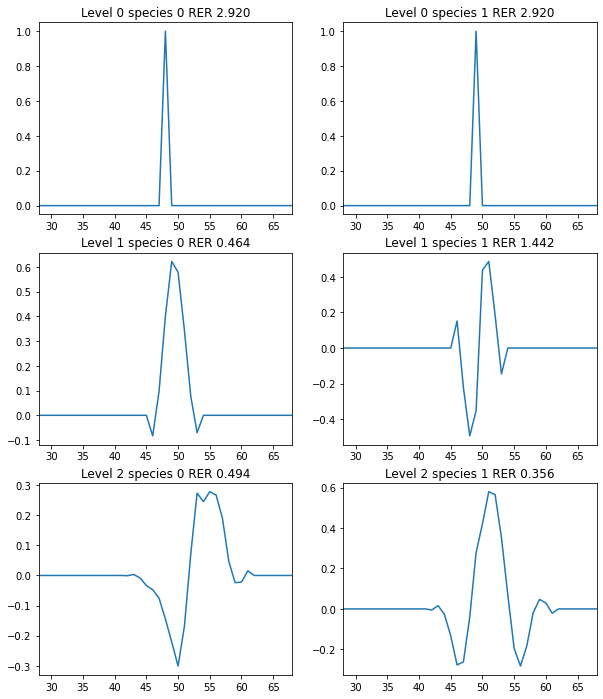

In [42]:
fig, axs = plt.subplots(len(ml), num_components, figsize=(10, 4 * len(ml)))

for l in range(len(ml)):
    m = ml[l].size
    i = m // 2
    for col, j in enumerate(range(i, i + num_components)):
        u = np.zeros((m,))
        u[j] = 1
        for ll in range(l, 0, -1):
            u = ml[ll]._p.dot(u)
        ax = axs[l, col]
        ax.set_title("Level {} species {} RER {:.3f}".format(l, col, norm(ml[0].operator(u)) / norm(u)))
        ax.plot(u);
        ax.set_xlim(ml[0].size // 2 - 20, ml[0].size // 2 + 20);

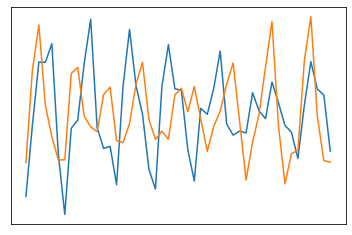

In [43]:
plt.plot(x[:, 0])
plt.plot(x[:, 1])
plt.xticks([], []);
plt.yticks([], []);
plt.savefig("tf.png")